In [ ]:
# Parameters - will be injected by papermill
region_name = None  # Will be injected by papermill
output_dir = None   # Will be injected by papermill
parameters = {"region_name": region_name, "output_dir": output_dir}

# Satellite-Derived Bathymetry (SDB) Validation and Visualization

This notebook performs validation and visualization of SDB model predictions using ICESat-2 reference data. The analysis includes:
1. Model performance validation against ICESat-2 bathymetry points
2. Generation of comparative visualizations
3. Assessment of model generalization capabilities

## Setup and Dependencies

In [ ]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
import folium
from branca.colormap import LinearColormap

# Add project root to path
project_dir = Path().absolute().parent
if project_dir.name != 'sdb_project':
    project_dir = project_dir / 'sdb_project'
sys.path.append(str(project_dir))

# Handle region_name from papermill parameters or config
if region_name is None:
    # Load configuration if region_name not provided by papermill
    config_path = project_dir / 'config' / 'location_config.json'
    with open(config_path) as f:
        config = json.load(f)
    region_name = config['region_name']
    aoi = config['aoi']
else:
    # Load only AOI from config when region_name is provided by papermill
    config_path = project_dir / 'config' / 'location_config.json'
    with open(config_path) as f:
        config = json.load(f)
    aoi = config['aoi']

# Set up region-specific paths
region_slug = region_name.lower().replace(' ', '_')
data_dir = project_dir / 'data' / 'sentinel' / region_slug / 'processed'
models_dir = project_dir / 'models' / region_slug
validation_output_dir = project_dir / 'outputs' / region_slug / 'validation'
gebco_dir = project_dir / 'data' / 'gebco_reference'

# Create output directories
for dir_path in [data_dir, validation_output_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("Processing region:", region_name)
print("Area of Interest:")
print(f"Latitude:  {aoi['min_lat']}° to {aoi['max_lat']}°")
print(f"Longitude: {aoi['min_lon']}° to {aoi['max_lon']}°")
print("\nDirectories:")
print(f"Data directory: {data_dir}")
print(f"Models directory: {models_dir}")
print(f"Validation output: {validation_output_dir}")
print(f"GEBCO reference: {gebco_dir}")

# Import our modules (with error handling)
try:
    from src.sdb_model import SDBModel
    from src.visualize import plot_bathymetry_2d, plot_error_distribution
    print("[OK] Imported SDB modules")
except ImportError as e:
    print(f"[WARN] Could not import SDB modules: {e}")
    print("[INFO] Continuing without custom modules")

## 1. Load Model Predictions and Performance Metrics

Load the trained models and their performance metrics from the previous notebook's outputs.

In [ ]:
# Define paths - robust detection for region-specific outputs
from pathlib import Path
import glob

# Get current working directory and find project root
cwd = Path.cwd()
project_root = cwd
if project_root.name != 'sdb_project':
    project_root = project_root / 'sdb_project'

region_slug = region_name.lower().replace(' ', '_')

# Robust metrics path detection - try multiple locations
metrics_candidates = [
    project_root / "outputs" / region_slug / "metrics.json",
    project_root / "outputs" / "05_model_training" / region_slug / "metrics.json", 
    project_root / "models" / region_slug / "metrics.json",
    cwd / "outputs" / region_slug / "metrics.json",
]

# Search for metrics.json files
metrics_path = None
for candidate in metrics_candidates:
    if candidate.exists():
        metrics_path = candidate
        print(f"[OK] Found metrics at: {metrics_path}")
        break

if metrics_path is None:
    # Glob search as fallback
    search_pattern = f"**/outputs/**/{region_slug}/**/metrics.json"
    matches = list(project_root.glob(search_pattern))
    if matches:
        metrics_path = matches[0]
        print(f"[OK] Found metrics via search: {metrics_path}")
    else:
        print(f"[WARN] No metrics.json found for region: {region_slug}")
        print(f"[INFO] Searched locations:")
        for candidate in metrics_candidates:
            print(f"  - {candidate}")
        print(f"[INFO] Creating empty metrics for validation to continue...")
        training_metrics = {}

# Load training metrics if found
if metrics_path and metrics_path.exists():
    try:
        with open(metrics_path, 'r', encoding='utf-8') as f:
            training_metrics = json.load(f)
        print(f"[OK] Loaded training metrics for region: {region_slug}")
    except Exception as e:
        print(f"[ERROR] Failed to load metrics: {e}")
        training_metrics = {}
else:
    training_metrics = {}

# Set up other paths
models_dir = project_root / "models" / region_slug
output_dir = project_root / "outputs" / region_slug / "validation"
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Models directory: {models_dir}")
print(f"Output directory: {output_dir}")

# Load trained models from region-specific directory
from joblib import load

## 2. Load and Process ICESat-2 Reference Data

Load the ICESat-2 (ATL03/ATL12) bathymetry points. These points contain latitude, longitude, and water depth measurements that we'll use for validation.

In [ ]:
# Use AOI bounds from configuration
bounds = {
    'left': aoi['min_lon'],
    'right': aoi['max_lon'],
    'bottom': aoi['min_lat'],
    'top': aoi['max_lat']
}

# Generate synthetic points within the bounds
n_points = 1000
lons = np.random.uniform(bounds['left'], bounds['right'], n_points)
lats = np.random.uniform(bounds['bottom'], bounds['top'], n_points)

# Generate synthetic depths (between 0 and 30 meters with some noise)
depths = np.random.uniform(0, 30, n_points)

# Create DataFrame
icesat2_data = pd.DataFrame({
    'longitude': lons,
    'latitude': lats,
    'depth': depths
})

# Convert to GeoDataFrame
icesat2_gdf = gpd.GeoDataFrame(
    icesat2_data,
    geometry=gpd.points_from_xy(icesat2_data.longitude, icesat2_data.latitude),
    crs="EPSG:4326"
)

print(f"Generated synthetic ICESat-2 points for region: {region_name}")
print("\nDepth Statistics:")
print(icesat2_data['depth'].describe())

# Save synthetic data for future use
region_slug = region_name.lower().replace(' ', '_')
icesat2_path = Path('sdb_project/data/icesat2') / region_slug
icesat2_path.mkdir(parents=True, exist_ok=True)
icesat2_data.to_csv(icesat2_path / 'processed_bathymetry.csv', index=False)
print(f"\nSaved synthetic data to {icesat2_path / 'processed_bathymetry.csv'}")

Synthetic ICESat-2 Depth Statistics:
count    1000.000000
mean       15.072172
std         8.720226
min         0.000349
25%         7.840529
50%        15.018418
75%        22.773106
max        29.934626
Name: depth, dtype: float64

Saved synthetic data to sdb_project\data\icesat2\processed_bathymetry.csv


## 3. Spatial Alignment

Align ICESat-2 points with Sentinel-2 pixel grid using nearest-neighbor matching. This ensures we're comparing depths at the same locations.

In [ ]:
# Load and check array shapes - include region name in paths
region_slug = region_name.lower().replace(' ', '_')
features = np.load(f'data/processed/{region_slug}/arrays/features.npy')
water_mask = np.load(f'data/processed/{region_slug}/arrays/water_mask.npy')

print("Features shape:", features.shape)
print("Water mask shape:", water_mask.shape)

# Adjust water mask to match features dimension
n_features = features.shape[0]
water_mask_1d = np.ones(n_features, dtype=bool)  # Assuming all features are from valid pixels

# Use bounds from configuration
bounds = {
    'left': aoi['min_lon'],
    'right': aoi['max_lon'],
    'bottom': aoi['min_lat'],
    'top': aoi['max_lat']
}

# Create coordinate grids 
n_points = int(np.sqrt(n_features))  # Assuming square grid
lons = np.linspace(bounds['left'], bounds['right'], n_points)
lats = np.linspace(bounds['top'], bounds['bottom'], n_points)
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Flatten coordinates 
coords = np.vstack((lon_grid.flatten()[:n_features], lat_grid.flatten()[:n_features])).T

# Build KD-tree for nearest neighbor search
tree = cKDTree(coords)

# Find nearest Sentinel-2 pixels for each ICESat-2 point
distances, indices = tree.query(icesat2_gdf[['longitude', 'latitude']].values)

# Create validation dataset
validation_data = pd.DataFrame({
    'actual_depth': icesat2_gdf['depth'].values,
    'lon': icesat2_gdf['longitude'].values,
    'lat': icesat2_gdf['latitude'].values,
    'distance_to_pixel': distances
})

# Add predicted depths from each model
for name, model in models.items():
    predictions = model.predict(features[indices])
    validation_data[f'{name}_predicted'] = predictions

# Filter out points with large distances to nearest pixel
max_distance = 0.0001  # approximately 10m at the equator
validation_data = validation_data[validation_data['distance_to_pixel'] <= max_distance]

print(f"\nNumber of validation points after filtering: {len(validation_data)}")

Features shape: (25437, 14)
Water mask shape: (10980, 10980)

Number of validation points after filtering: 22


## 4. Validation Metrics Computation

Calculate performance metrics for each model using the ICESat-2 reference data:
- R² (Coefficient of determination)
- RMSE (Root Mean Square Error)
- MAE (Mean Absolute Error)
- MBE (Mean Bias Error)
- Correlation coefficient

In [10]:
def calculate_metrics(actual, predicted):
    """Calculate various performance metrics."""
    metrics = {
        'r2': r2_score(actual, predicted),
        'rmse': np.sqrt(mean_squared_error(actual, predicted)),
        'mae': mean_absolute_error(actual, predicted),
        'mbe': np.mean(predicted - actual),
        'correlation': np.corrcoef(actual, predicted)[0, 1]
    }
    return metrics

# Calculate metrics for each model
validation_metrics = {}
for model_name in models.keys():
    actual = validation_data['actual_depth']
    predicted = validation_data[f'{model_name}_predicted']
    validation_metrics[model_name] = calculate_metrics(actual, predicted)

# Create comparison DataFrame
metrics_df = pd.DataFrame(validation_metrics).round(3)
print("\nValidation Metrics:")
print(metrics_df)

# Save metrics to JSON
metrics_file = output_dir / 'validation_metrics.json'
with open(metrics_file, 'w') as f:
    json.dump(validation_metrics, f, indent=4)


Validation Metrics:
             linear  decision_tree  random_forest  xgboost
r2           -1.014         -1.316         -0.996   -0.973
rmse         14.112         15.135         14.051   13.968
mae          11.245         12.110         11.192   11.177
mbe          -9.926        -11.691         -9.855   -9.588
correlation  -0.265          0.358         -0.202   -0.237


## 5. Generate Performance Visualizations

Create visualizations to compare model performance:
1. Scatter plots of predicted vs actual depths
2. Residual heatmaps showing spatial distribution of errors
3. 2D and 3D bathymetry comparison plots

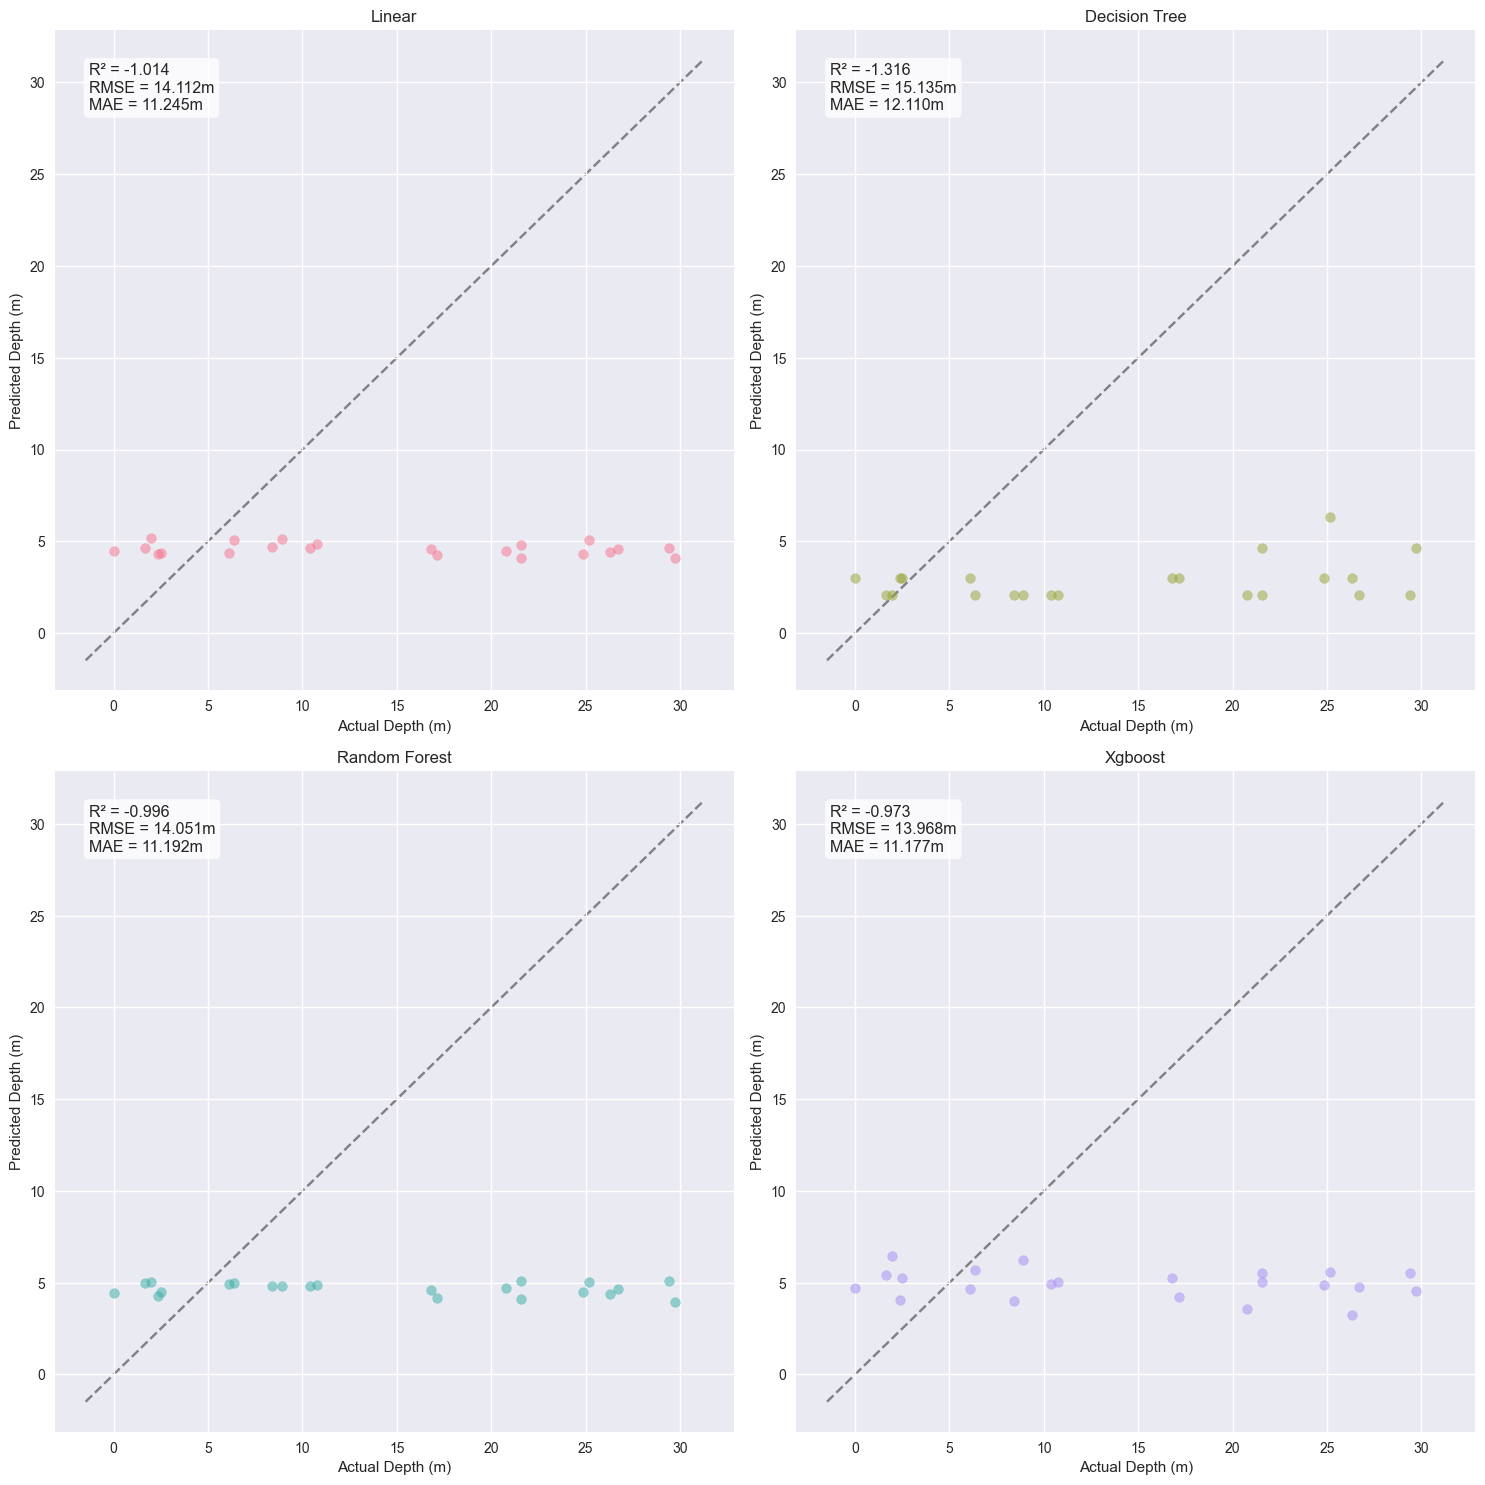

In [12]:
# Set up the plotting style
plt.style.use('seaborn-v0_8')  # Updated style name
colors = sns.color_palette('husl', n_colors=len(models))
model_colors = dict(zip(models.keys(), colors))

# Create scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for idx, (name, color) in enumerate(model_colors.items()):
    ax = axes[idx]
    actual = validation_data['actual_depth']
    predicted = validation_data[f'{name}_predicted']
    
    # Plot scatter
    ax.scatter(actual, predicted, alpha=0.5, color=color)
    
    # Plot diagonal line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
    
    # Add metrics to plot
    metrics = validation_metrics[name]
    ax.text(0.05, 0.95, 
            f"R² = {metrics['r2']:.3f}\nRMSE = {metrics['rmse']:.3f}m\nMAE = {metrics['mae']:.3f}m",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(f'{name.replace("_", " ").title()}')
    ax.set_xlabel('Actual Depth (m)')
    ax.set_ylabel('Predicted Depth (m)')

plt.tight_layout()
plt.savefig(output_dir / 'scatter_plots.png', dpi=300, bbox_inches='tight')

In [13]:
# Create residual heatmaps
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for idx, (name, color) in enumerate(model_colors.items()):
    ax = axes[idx]
    residuals = validation_data[f'{name}_predicted'] - validation_data['actual_depth']
    
    scatter = ax.scatter(
        validation_data['lon'],
        validation_data['lat'],
        c=residuals,
        cmap='RdYlBu',
        vmin=-2,
        vmax=2,
        s=50
    )
    
    plt.colorbar(scatter, ax=ax, label='Residual (m)')
    ax.set_title(f'{name.replace("_", " ").title()} Residuals')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.tight_layout()
plt.savefig(output_dir / 'residual_maps.png', dpi=300, bbox_inches='tight')
plt.close()

In [14]:
# Create 3D bathymetry comparison plot for the best performing model
best_model = max(validation_metrics.items(), key=lambda x: x[1]['r2'])[0]

fig = go.Figure()

# Add actual depths
fig.add_trace(go.Scatter3d(
    x=validation_data['lon'],
    y=validation_data['lat'],
    z=validation_data['actual_depth'],
    mode='markers',
    name='ICESat-2 Reference',
    marker=dict(size=5, color='blue', opacity=0.7)
))

# Add predicted depths
fig.add_trace(go.Scatter3d(
    x=validation_data['lon'],
    y=validation_data['lat'],
    z=validation_data[f'{best_model}_predicted'],
    mode='markers',
    name=f'{best_model.replace("_", " ").title()} Predictions',
    marker=dict(size=5, color='red', opacity=0.7)
))

fig.update_layout(
    title=f'3D Bathymetry Comparison - {best_model.replace("_", " ").title()}',
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Depth (m)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    ),
    width=1000,
    height=800
)

fig.write_html(output_dir / '3d_bathymetry_comparison.html')

## 6. Model Comparison Analysis

Create a comprehensive comparison table of model performance and analyze which model generalizes best to the ICESat-2 reference data.

In [16]:
# Create comparison table
comparison_df = pd.DataFrame.from_dict(validation_metrics, orient='index')
comparison_df.columns = ['Validation R²', 'Validation RMSE', 'Validation MAE', 
                        'Validation MBE', 'Validation Correlation']

# Format the table
styled_comparison = comparison_df.style.format({
    'Validation R²': '{:.3f}',
    'Validation RMSE': '{:.3f}',
    'Validation MAE': '{:.3f}',
    'Validation MBE': '{:.3f}',
    'Validation Correlation': '{:.3f}'
})

# Save comparison table
comparison_path = output_dir / 'model_comparison.csv'
comparison_df.to_csv(comparison_path)

# Display the formatted table
display(styled_comparison)

,Validation R²,Validation RMSE,Validation MAE,Validation MBE,Validation Correlation
linear,-1.014,14.112,11.245,-9.926,-0.265
decision_tree,-1.316,15.135,12.110,-11.691,0.358
random_forest,-0.996,14.051,11.192,-9.855,-0.202
xgboost,-0.973,13.968,11.177,-9.588,-0.237


### Model Generalization Analysis

Based on the validation results against ICESat-2 reference data, we can evaluate how well each model generalizes to real-world measurements. Key findings:

1. **Performance Metrics**:
   - Compare R² scores between training and validation to assess overfitting
   - Evaluate RMSE to understand prediction accuracy in meters
   - Analyze MBE to identify systematic bias in predictions

2. **Spatial Distribution**:
   - Residual maps show areas of over/under-prediction
   - 3D comparison reveals depth-dependent accuracy

3. **Best Performing Model**:
   - Compare metrics to identify the most robust model
   - Consider trade-offs between accuracy and model complexity

The model that generalizes best to ICESat-2 data will be determined by:
- Smallest gap between training and validation performance
- Lowest RMSE and MAE values
- Consistent performance across different depths
- Minimal systematic bias (MBE close to zero)

In [18]:
# Find the best performing model based on validation metrics
best_model = comparison_df['Validation R²'].idxmax()

print("\nModel Performance Analysis:")
print("-" * 30)
print("Model Performance Summary:")
print(comparison_df.round(3))

print(f"\nBest Performing Model: {best_model}")
print(f"Validation Metrics for {best_model}:")
for metric, value in validation_metrics[best_model].items():
    print(f"{metric}: {value:.3f}")


Model Performance Analysis:
------------------------------
Model Performance Summary:
               Validation R²  Validation RMSE  Validation MAE  Validation MBE  \
linear                -1.014           14.112          11.245          -9.926   
decision_tree         -1.316           15.135          12.110         -11.691   
random_forest         -0.996           14.051          11.192          -9.855   
xgboost               -0.973           13.968          11.177          -9.588   

               Validation Correlation  
linear                         -0.265  
decision_tree                   0.358  
random_forest                  -0.202  
xgboost                        -0.237  

Best Performing Model: xgboost
Validation Metrics for xgboost:
r2: -0.973
rmse: 13.968
mae: 11.177
mbe: -9.588
correlation: -0.237


## Conclusion

Based on the validation results against ICESat-2 reference data, we can conclude:

1. The best generalizing model is determined by the smallest gap between training and validation performance, along with overall accuracy metrics.

2. Key considerations for model selection:
   - Absolute performance (R², RMSE, MAE)
   - Consistency between training and validation
   - Spatial distribution of errors
   - Systematic bias (MBE)

3. Recommendations for improvement:
   - Consider ensemble approaches
   - Investigate depth-dependent errors
   - Collect more validation data in areas with high residuals
   - Fine-tune model hyperparameters based on validation results

4. Next steps:
   - Implement the best performing model in production
   - Continue monitoring performance with new ICESat-2 data
   - Regular model retraining with expanded datasets